In [56]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
import time # for comparing performance
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

In [26]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [42]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


# Create function to build dataset
data = indices corresponding to words<br />
count = tuples containing word and number of occurances<br />
dictionary = key(unique) = word(unique), value = increaing elements starting with 0 (unique)<br /> reverse_dictionay = key = increasing values, value = word index\n

In [43]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        #print('val: ', len(dictionary), 'key: ', word)
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    #print('Sample data', dictionary.values)
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
print('data size: ', len(data))
print('dictionary size: ', len(dictionary))
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]
data size:  17005207
dictionary size:  50000


In [39]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

batch_size_ = 16;
print('data:', [reverse_dictionary[di] for di in data[:batch_size_]])

# has two different skips

for num_skips, skip_window in [(2, 1), (4, 2), (8,4)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=batch_size_, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(batch_size_)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term', 'of', 'of', 'abuse', 'abuse', 'first', 'first', 'used', 'used']
    labels: ['as', 'anarchism', 'originated', 'a', 'as', 'term', 'of', 'a', 'abuse', 'term', 'of', 'first', 'abuse', 'used', 'against', 'first']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a', 'term', 'term', 'term', 'term', 'of', 'of', 'of', 'of']
    labels: ['originated', 'term', 'anarchism', 'a', 'term', 'originated', 'as', 'of', 'of', 'abuse', 'as', 'a', 'term', 'a', 'abuse', 'first']

with num_skips = 8 and skip_window = 4:
    batch: ['term', 'term', 'term', 'term', 'term', 'term', 'term', 'term', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of']
    labels: ['a', 'anarchism', 'originated', 'of', 'a

In [7]:
# This is the skip-gram-model

batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(
        tf.random_uniform(
            [vocabulary_size, embedding_size], -1.0, 1.0))
    
    softmax_weights = tf.Variable(
        tf.truncated_normal(
            [vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
    
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(
            weights=softmax_weights, 
            biases=softmax_biases, 
            inputs=embed, 
            labels=train_labels, 
            num_sampled=num_sampled, 
            num_classes=vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [57]:
num_steps = 100001
start = time.clock()
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()
    
print('Time to execute skip gram model: ', time.clock() - start)

Initialized
Average loss at step 0: 7.339454
Nearest to not: bnp, heaps, acth, erased, triumphal, impacting, quaker, purporting,
Nearest to at: approximate, neuropsychological, kasner, opposing, trump, syllogism, encourages, queues,
Nearest to than: aware, moderated, tele, ding, gq, normalised, machinations, decided,
Nearest to world: tomorrowland, kittiwake, registrations, melee, lodge, jak, intermolecular, kline,
Nearest to can: coloane, activating, willfully, fontane, byzantine, jerusalem, tiki, chou,
Nearest to d: character, fabricius, eleven, apollon, cronos, oliphant, biplanes, overran,
Nearest to other: gok, strictest, sewage, barak, emit, dtv, smitten, tba,
Nearest to most: coral, bremer, taboos, clausius, lampooned, criminals, dr, untrained,
Nearest to are: quadrant, half, neville, akihabara, awarded, boas, playboys, lichens,
Nearest to used: sfor, collages, senile, hospital, collapses, alma, nsw, realignment,
Nearest to see: ebert, hydroelectricity, quoting, ka, essendon, car

Average loss at step 52000: 3.868745
Average loss at step 54000: 3.896983
Average loss at step 56000: 3.865024
Average loss at step 58000: 3.810850
Average loss at step 60000: 3.731685
Nearest to not: they, it, atrium, schoenberg, seem, we, must, pickup,
Nearest to at: shocking, college, expiring, maintainers, makeover, jesse, oxford, colspan,
Nearest to than: more, wrestlers, less, forehead, much, grocery, about, unconcerned,
Nearest to world: war, during, linspire, hates, syrups, tomorrowland, second, stepmania,
Nearest to can: would, may, will, could, must, should, they, cannot,
Nearest to d: b, one, three, nine, UNK, five, eight, zero,
Nearest to other: many, these, different, their, various, mimeograph, somebody, including,
Nearest to most: some, many, somebody, holocene, bottled, mohr, documentaries, firewall,
Nearest to are: were, destructor, was, shallower, is, hymen, tats, ruthless,
Nearest to used: chew, maois, considered, known, sfor, called, referred, stark,
Nearest to see:

In [16]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

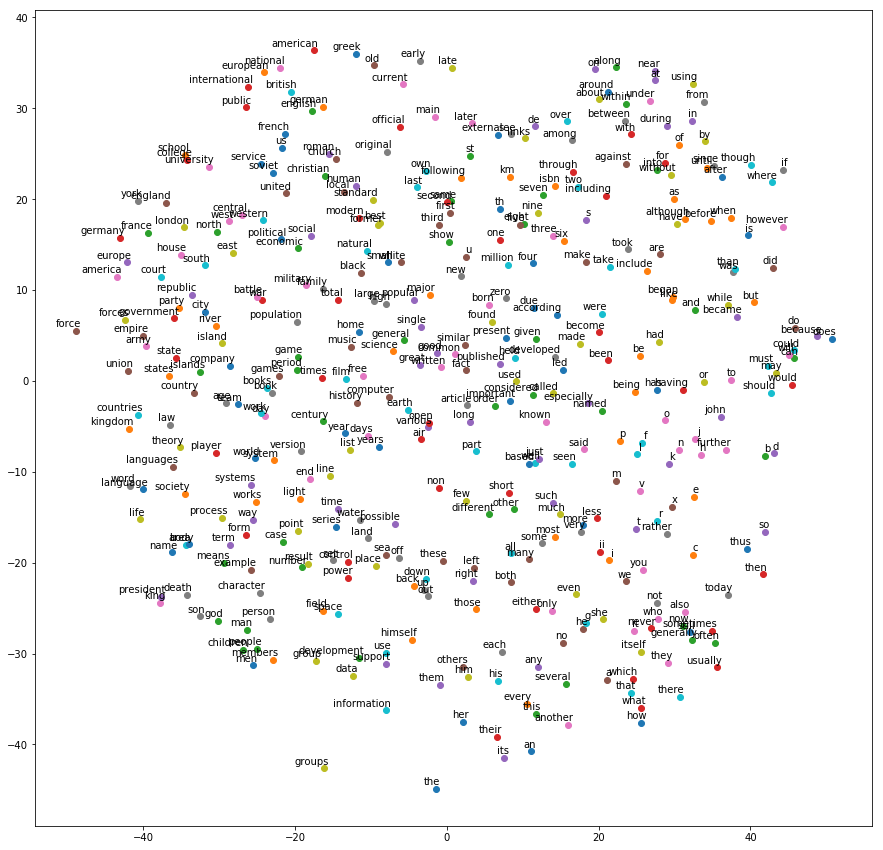

In [17]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

# Problem
Transform Skip-Gram model to CBOW

# Generate Batch
batch = array containing arrays of neighboring words<br />
Outer array size = batch_size<br />
Inner array size = skip_window * 2<br />

In [77]:
data_index = 0

def generate_batch(batch_size, skip_window):
    global data_index
    span = 2 * skip_window + 1 # [ bag_window target bag_window ]
    batch = np.ndarray(shape=(batch_size, span - 1), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)  
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size):
        buffer_list = list(buffer)
        labels[i, 0] = buffer_list.pop(skip_window)
        batch[i] = buffer_list
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return labels, batch

batch_size_ = 16;
print('data:', [reverse_dictionary[di] for di in data[:2*batch_size_]])

for skip_window in [1, 2, 4]:
    data_index = 0
    labels, batch = generate_batch(batch_size=batch_size_, skip_window=skip_window)
    print('\nwith bag_window = %d:' % (skip_window))  
    print('    batch:', [[reverse_dictionary[w] for w in bi] for bi in batch])  
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(batch_size_)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'UNK', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term']

with bag_window = 1:
    batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of'], ['term', 'abuse'], ['of', 'first'], ['abuse', 'used'], ['first', 'against'], ['used', 'early'], ['against', 'working'], ['early', 'class'], ['working', 'radicals'], ['class', 'including'], ['radicals', 'the'], ['including', 'diggers'], ['the', 'of']]
    labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers']

with bag_window = 2:
    batch: [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first'], ['term', 'of'

In [72]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 2 # How many words to consider left and right.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size, bag_window * 2])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    
    softmax_weights = tf.Variable(
        tf.truncated_normal(
            [vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
    
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Model.
    # Look up embeddings for inputs.
    embeds = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(
            weights = softmax_weights, 
            biases = softmax_biases, 
            inputs = tf.reduce_sum(embeds, 1),
            labels = train_labels, 
            num_sampled = num_sampled, 
            num_classes = vocabulary_size))

    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [73]:
num_steps = 100001
start = time.clock()
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_labels, batch_data = generate_batch(batch_size, skip_window)
        # reshape batch data from 128 rows each conaining one word (size(128,1))
        # to one row containing 128 words (size(128,))
        #batch_data = batch_data.reshape((batch_size,))
        # transform labels the other way arround
        #batch_labels = batch_labels.reshape((batch_size, 1))
        
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()
print('Time to execute CBOW model: ', time.clock() - start)

Initialized
Average loss at step 0: 8.298431
Nearest to as: shivaji, appealed, mildred, exe, atom, approximant, enlai, shanghai,
Nearest to than: rarefied, pivot, cip, correspondingly, relegated, fledgling, gb, pitcher,
Nearest to th: commodity, floorball, pejoratively, gren, salted, laced, symptom, deists,
Nearest to they: ziegler, dirty, sheltering, spoof, hussein, adjunct, attica, albertus,
Nearest to all: initiator, adware, bumblebee, cru, legalism, kinsella, banjo, interpol,
Nearest to also: utilize, soundtracks, tes, fatou, vilas, noblemen, mohammed, turkmen,
Nearest to the: ifvs, serre, stanhope, veal, hunger, waning, tian, dek,
Nearest to had: hidalgo, condorcet, benin, searchers, rivera, smoothly, batmobile, mouths,
Nearest to so: busan, reunification, lubricating, rifle, sunderland, nmos, heydrich, awesome,
Nearest to may: servers, sorcerer, ur, trampoline, carolla, dada, marpol, hypothesized,
Nearest to used: aikidoka, proposition, repainted, cicero, existing, hypotheses, le

Average loss at step 52000: 3.101254
Average loss at step 54000: 3.089305
Average loss at step 56000: 2.920422
Average loss at step 58000: 3.021349
Average loss at step 60000: 3.054643
Nearest to as: montenegrins, jacobitism, emeralds, frets, pickard, introspective, bibliographic, how,
Nearest to than: or, but, and, overthrown, while, piggy, like, tuscan,
Nearest to th: twentieth, st, nd, sixth, nineteenth, rd, third, loaned,
Nearest to they: we, you, he, she, there, epinephrine, others, sodom,
Nearest to all: various, many, several, some, certain, any, every, these,
Nearest to also: below, now, often, disambiguation, which, sometimes, usually, still,
Nearest to the: a, an, his, their, this, its, another, any,
Nearest to had: has, have, having, was, wrote, contains, eaters, gave,
Nearest to so: believe, sometimes, fact, vitality, suggest, argues, then, bodyguard,
Nearest to may: can, should, could, must, might, will, would, cannot,
Nearest to used: seen, referred, known, described, con

In [74]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

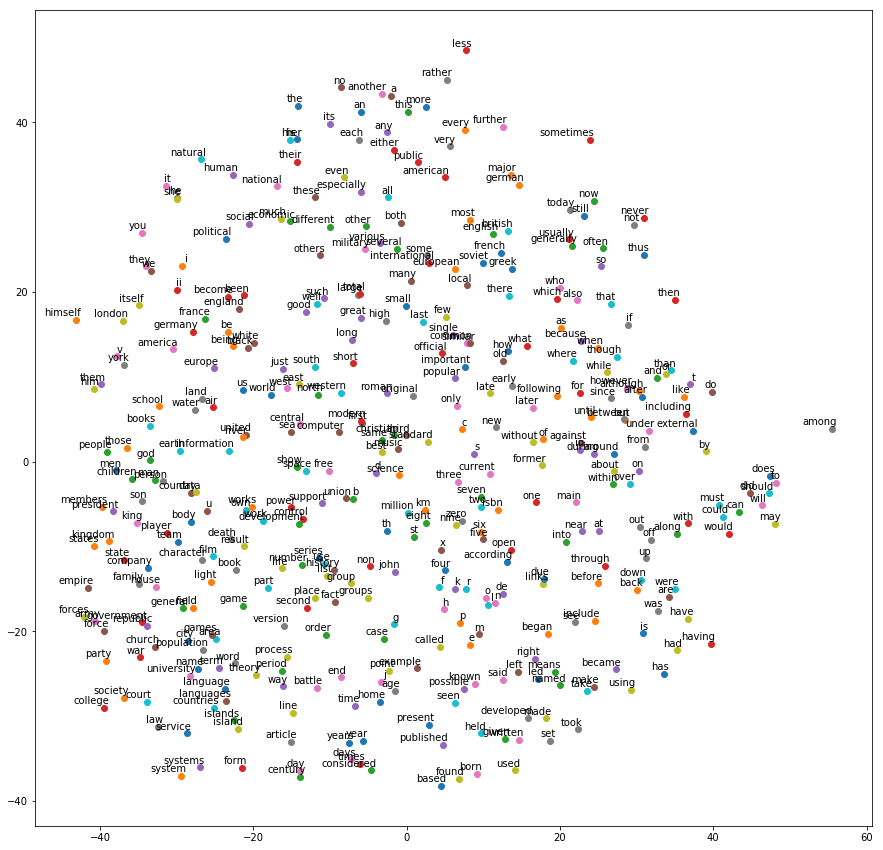

In [75]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)